# MetaTiME for Cell State Annotator and Cell Signature Mapper

### installation for colab

In [4]:
##Calling matplotlib first help avoid error in colab when plotting
import matplotlib
import matplotlib.pyplot as plt
!wget -q https://www.dropbox.com/s/gnmgfxa85basvwq/logo.png
img = matplotlib.image.imread('./logo.png', 0)

logo = plt.imshow( img )
_=plt.axis('off')

## install
!pip install scanpy 
!pip install git+https://github.com/yi-zhang/MetaTiME.git
!pip install anndata
!pip install adjustText
!pip install leidenalg



## imports

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import seaborn as sns
import scanpy as sc


import importlib as imp
import metatime
from metatime import config
from metatime import loaddata
from metatime import mecmapper
from metatime import mecs
from metatime import annotator
from metatime import plmapper
import matplotlib

## Get sample data

In [ ]:

#!wget -O testdata.h5ad https://www.dropbox.com/s/0sj6gtppsfr2ouo/NSCLC_GSE117570_res.pp.h5ad?dl=0

!wget -O testdata.h5ad https://www.dropbox.com/s/f791mv3tnhs9fii/BCC_GSE123813_aPD1_with_metainfo.h5ad

## Load scRNA data

In [ ]:
file = 'testdata.h5ad' 

### Or provide path to local file

In [3]:
file = '../notebooks_dev/BCC_GSE123813_aPD1_with_metainfo.h5ad' # Yost et al. 2019 Nat Med.

### Load data

In [4]:
adata = loaddata.load(file = file)

 Loaded ../notebooks_dev/BCC_GSE123813_aPD1_with_metainfo.h5ad


## Processing and Harmonize

If your data contains count matrix, we provide a wrapped function for pre-processing the data.

Otherwise, if the data is already depth-normalized, log-transformed, and cells are filtered, we can skip this step.

In [21]:
# adata = loaddata.adatapp( adata )

The sample data has multiple patients , and we can use batch correction on patients.


In [5]:
batchcols = ['patient']
adata = loaddata.batchharmonize( adata, batchcols = batchcols, random_state = 0 )  

[Log ] hamonize with batch  ['patient']


2022-05-10 16:42:09,748 - harmonypy - INFO - Iteration 1 of 10
2022-05-10 16:42:26,907 - harmonypy - INFO - Iteration 2 of 10
2022-05-10 16:42:43,029 - harmonypy - INFO - Iteration 3 of 10
2022-05-10 16:42:59,079 - harmonypy - INFO - Iteration 4 of 10
2022-05-10 16:43:16,039 - harmonypy - INFO - Iteration 5 of 10
2022-05-10 16:43:32,164 - harmonypy - INFO - Iteration 6 of 10
2022-05-10 16:43:45,297 - harmonypy - INFO - Iteration 7 of 10
2022-05-10 16:43:55,622 - harmonypy - INFO - Iteration 8 of 10
2022-05-10 16:44:13,335 - harmonypy - INFO - Iteration 9 of 10
2022-05-10 16:44:30,509 - harmonypy - INFO - Iteration 10 of 10
2022-05-10 16:44:46,140 - harmonypy - INFO - Stopped before convergence


[Log ] Recomputing umap 


It is recommended that malignant cells are identified first and removed for best practice in cell state annotation.

In the BCC data, the cluster of malignant cells are identified with inferCNV. We can use the pre-saved column 'isTME' to keep Tumor Microenvironment cells

In [6]:
adata = adata[adata.obs['isTME']]

We can over-cluster the cells which is useful for fine-grained cell state annotation.

In [7]:
adata = annotator.overcluster( adata ) # this generates a 'overcluster' columns in adata.obs

Trying to set attribute `.obs` of view, copying.


## Load MetaTiME trained model for TME

Next, let's load the pre-computed MetaTiME MetaComponents (MeCs), and their functional annotation.

In [8]:
# Load the pre-trained MeCs
mecmodel = mecs.MetatimeMecs.load_mec_precomputed()

# Load functional annotation for MetaTiME-TME
mectable = mecs.load_mecname( mecDIR = config.SCMECDIR, mode ='table' )
mecnamedict = mecs.getmecnamedict_ct(mectable) 


## Project on MeC space

We can project each cell onto this functional MeC space.

In [9]:
pdata = mecmapper.projectMecAnn(adata, mecmodel.mec_score)

### Per-cell score projected on MeC space

Convert to table to look at per-cell projection scores

In [10]:
projmat, mecscores = annotator.pdataToTable(pdata, mectable, gcol = 'overcluster')
mecscores[ :4 ]

Interferon_response  Proliferation_S  \
bcc.su001.pre.tcell_AAACCTGCAGGGATTG            -0.819890        -0.688164   
bcc.su001.pre.tcell_AAACGGGCATAGACTC             0.497730        -0.781702   
bcc.su001.pre.tcell_AAACGGGTCATACGGT            -0.853597         0.389129   
bcc.su001.pre.tcell_AAAGATGAGACAGGCT             1.643644        -0.217423   

                                      Heat_stress       pDC   Bplasma  \
bcc.su001.pre.tcell_AAACCTGCAGGGATTG    -1.293394 -0.623175 -0.619621   
bcc.su001.pre.tcell_AAACGGGCATAGACTC    -1.236870 -0.225077 -0.407063   
bcc.su001.pre.tcell_AAACGGGTCATACGGT     2.834898 -0.235956  0.469343   
bcc.su001.pre.tcell_AAAGATGAGACAGGCT    -0.643116  0.088754 -0.523546   

                                      Proliferation_G2/M  cDC2_MHCII  \
bcc.su001.pre.tcell_AAACCTGCAGGGATTG           -0.014213   -0.421470   
bcc.su001.pre.tcell_AAACGGGCATAGACTC           -0.196667   -0.708806   
bcc.su001.pre.tcell_AAACGGGTCATACGGT            0.946867   -0.673814   
bcc.su001.pre.tcell_AAAGATGAGACAGGCT           -1.255705   -0.849190   

                                      Treg_T-co-signaling  Cytotoxic_NK  \
bcc.su001.pre.tcell_AAACCTGCAGGGATTG            -0.575049      0.806688   
bcc.su001.pre.tcell_AAACGGGCATAGACTC             0.148677      1.226127   
bcc.su001.pre.tcell_AAACGGGTCATACGGT             0.078563      1.469857   
bcc.su001.pre.tcell_AAAGATGAGACAGGCT             0.658166     -0.770305   

                                      Mono_CD16  ...  Bplasma_1  CD4T_IL7R  \
bcc.su001.pre.tcell_AAACCTGCAGGGATTG  -0.228148  ...  -0.503919   1.365941   
bcc.su001.pre.tcell_AAACGGGCATAGACTC   0.229111  ...  -0.964028  -0.869057   
bcc.su001.pre.tcell_AAACGGGTCATACGGT   0.388126  ...  -0.713808   1.094122   
bcc.su001.pre.tcell_AAAGATGAGACAGGCT   1.756781  ...  -1.132153   1.547834   

                                        MeC_79    MeC_80  Fibro_VEGF  \
bcc.su001.pre.tcell_AAACCTGCAGGGATTG  0.532829  1.303657   -0.015501   
bcc.su001.pre.tcell_AAACGGGCATAGACTC -0.948729  0.932158   -1.617307   
bcc.su001.pre.tcell_AAACGGGTCATACGGT  1.178537 -2.930747   -2.534621   
bcc.su001.pre.tcell_AAAGATGAGACAGGCT -1.547482  0.496351   -1.177201   

                                        MeC_82  MeC_83_Mye/Fibro    MeC_84  \
bcc.su001.pre.tcell_AAACCTGCAGGGATTG -0.200811          2.227211 -2.101272   
bcc.su001.pre.tcell_AAACGGGCATAGACTC -0.813145         -0.541694 -1.985215   
bcc.su001.pre.tcell_AAACGGGTCATACGGT  1.399297         -0.640663  2.175453   
bcc.su001.pre.tcell_AAAGATGAGACAGGCT -0.764956          0.551764  0.479404   

                                        MeC_85  overcluster  
bcc.su001.pre.tcell_AAACCTGCAGGGATTG  0.964769          103  
bcc.su001.pre.tcell_AAACGGGCATAGACTC  0.821645           71  
bcc.su001.pre.tcell_AAACGGGTCATACGGT -1.674753            9  
bcc.su001.pre.tcell_AAAGATGAGACAGGCT -0.165305            8  

[4 rows x 87 columns]

## Cell state annotator and save the results to scRNA objects

Based on per-cell projection scores, compute the per-cluster cell state scores, and find out the top 1st enriched cell state.

Save the cluster-wise cell state annotation.

Or, it can also be saved to the scanpy object containing only the scores, which is smaller to save.

In [11]:
projmat, gpred, gpreddict = annotator.annotator( projmat,  mecnamedict, gcol = 'overcluster')

adata = annotator.saveToAdata( adata, projmat )
pdata = annotator.saveToPdata( pdata, adata, projmat )


/liulab/yiz/proj/MetaTiME/metatime/annotator.py:186: UserWarning: Columns in projmat already overlap columns in adata.obs. Overwriting adata.obs. 
  warnings.warn('Columns in projmat already overlap columns in adata.obs. Overwriting adata.obs. '


### Plot per-cluster, Top1 enriched cell states 

/homes6/yiz/Tools/pip/pippy3/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'MetaTiME_overcluster' as categorical


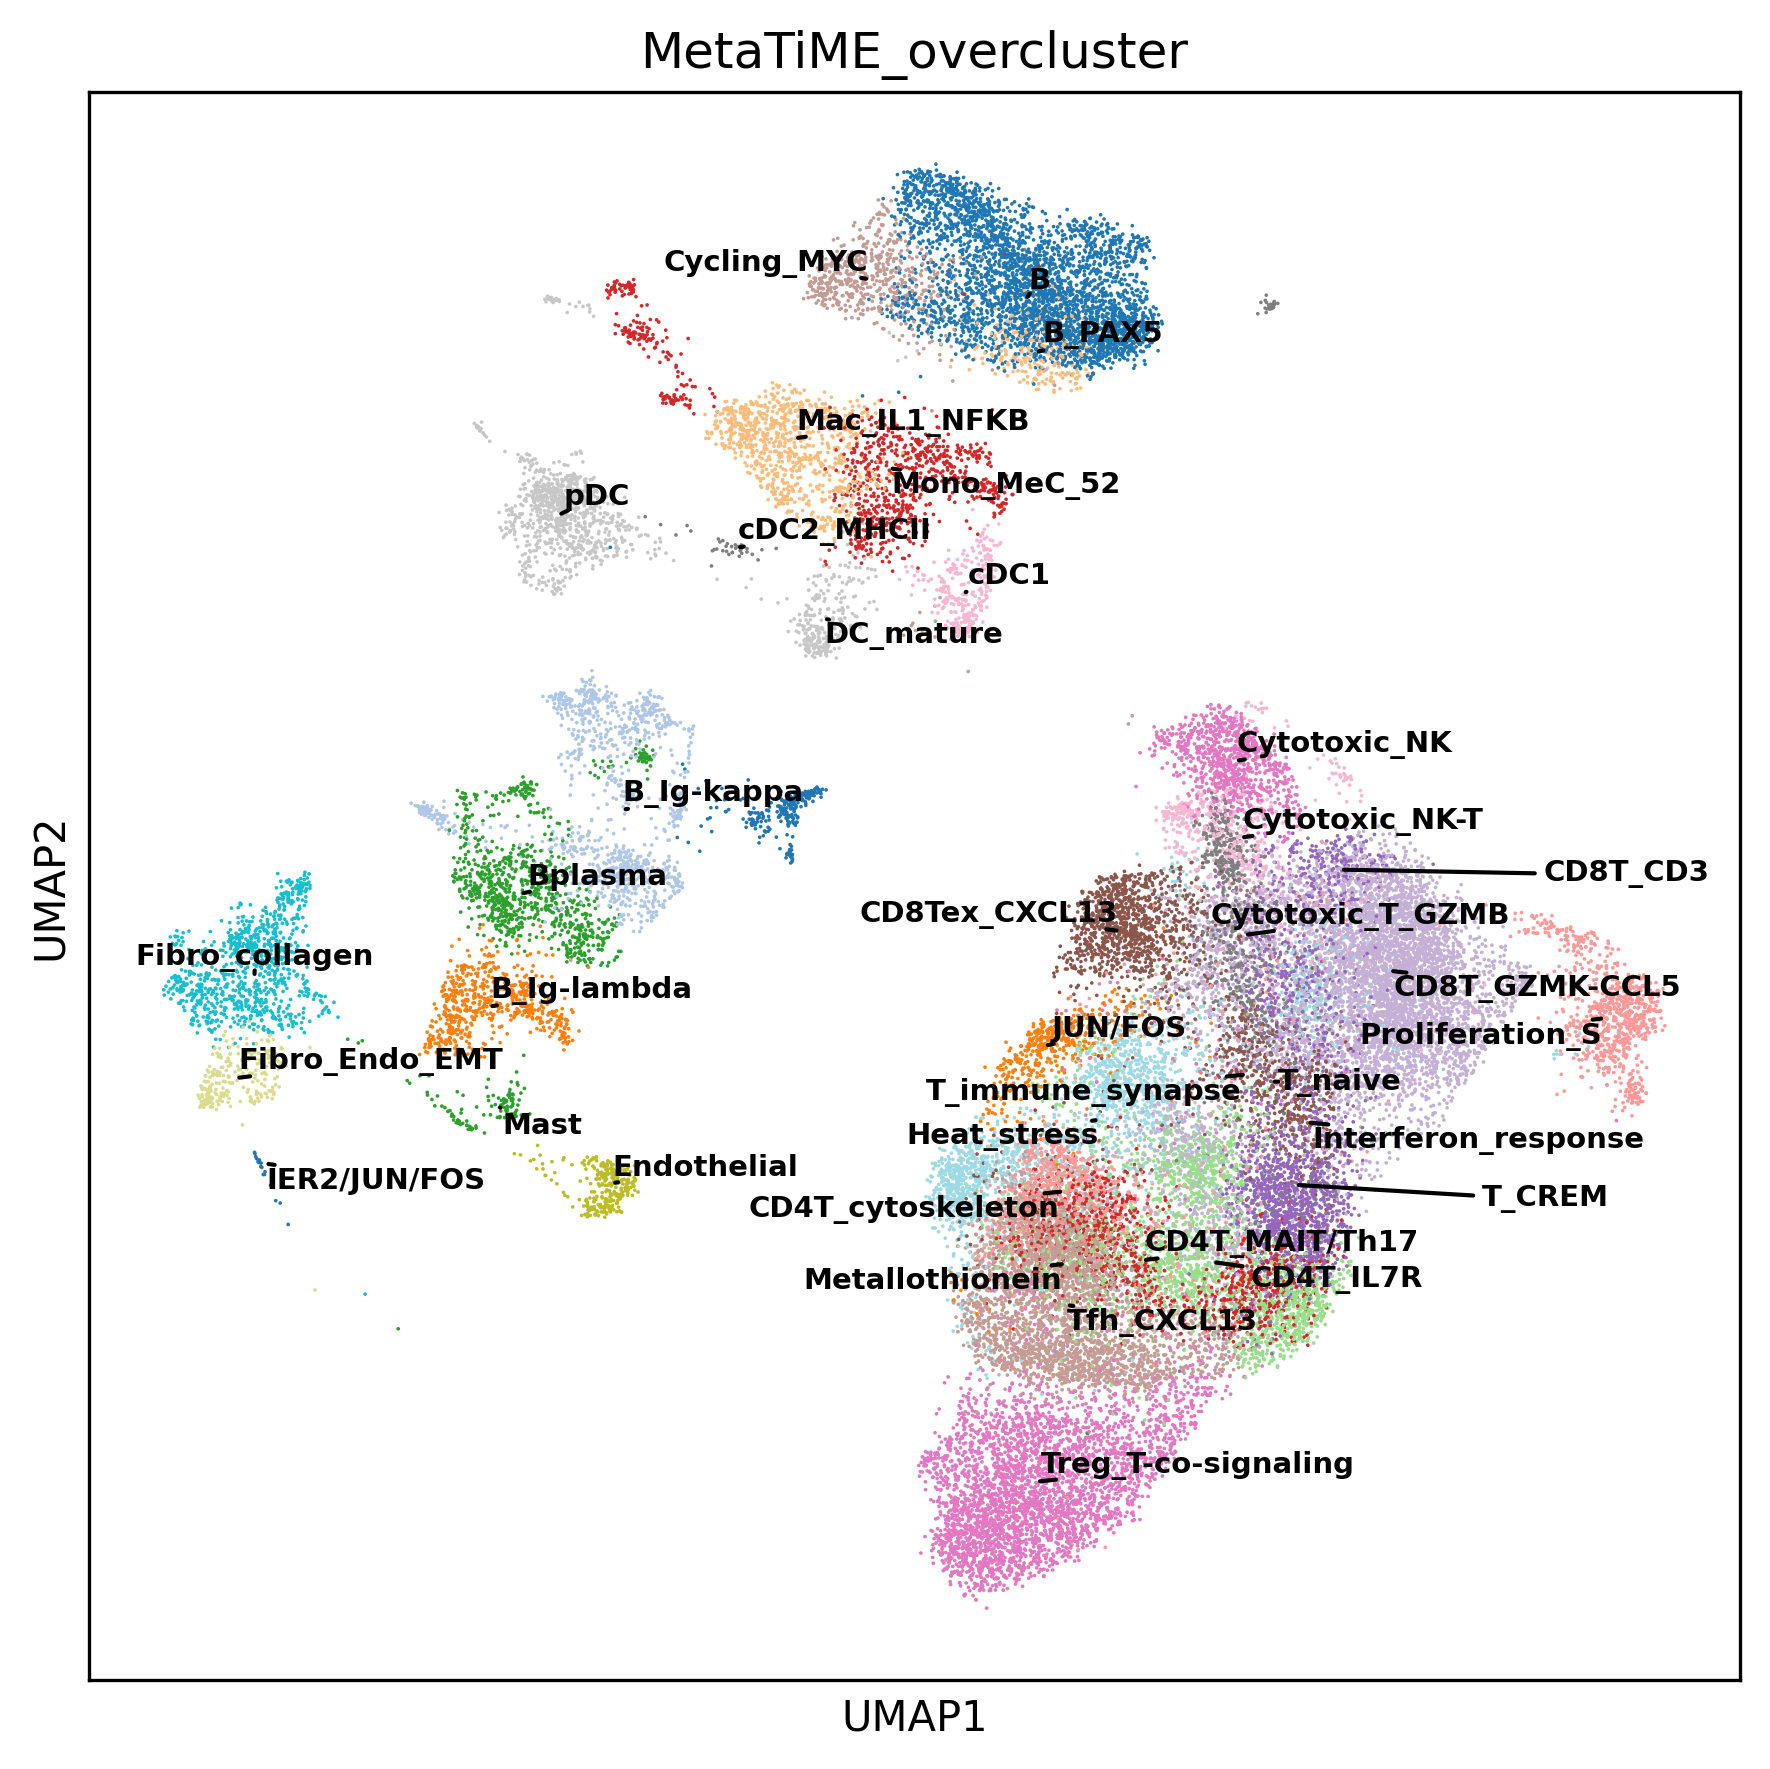

In [12]:
fig,ax = plmapper.plot_annotation_on_data( adata, fontsize=7 )

### Check the list of MeCs

In [23]:
mectable[['MeC_id','Annotation']].set_index('MeC_id').to_dict()['Annotation']

{'MeC_0': 'Interferon_response',
 'MeC_1': 'Proliferation_S',
 'MeC_2': 'Heat_stress',
 'MeC_3': 'pDC',
 'MeC_4': 'Bplasma',
 'MeC_5': 'Proliferation_G2/M',
 'MeC_6': 'cDC2_MHCII',
 'MeC_7': 'Treg_T-co-signaling',
 'MeC_8': 'Cytotoxic_NK',
 'MeC_9': 'Mono_CD16',
 'MeC_10': 'Mito.',
 'MeC_11': 'Cytotoxic_NK-T',
 'MeC_12': 'CD8T_GZMK-CCL5',
 'MeC_13': 'Mast',
 'MeC_14': 'Proliferation_2',
 'MeC_15': 'Ribosome',
 'MeC_16': 'CD4T_MAIT/Th17',
 'MeC_17': 'Mono_CD14',
 'MeC_18': 'B',
 'MeC_19': 'Mac_C1Q',
 'MeC_20': 'Tfh_CXCL13',
 'MeC_21': 'CD4T_cytoskeleton',
 'MeC_22': 'Fibro_collagen',
 'MeC_23': 'Endothelial',
 'MeC_24': 'Metallothionein',
 'MeC_25': 'Cytotoxic_T_GZMB',
 'MeC_26': 'Mac_SPP1',
 'MeC_27': 'Fibro_Endo_EMT',
 'MeC_28': 'Beta_catenin',
 'MeC_29': 'Mono_CD14_1',
 'MeC_30': 'B_Ig-kappa',
 'MeC_31': 'protein_processing',
 'MeC_32': 'CD8T_CD3',
 'MeC_33': 'Cycling_MYC',
 'MeC_34': 'IFNG-CCL3/4_NK-T',
 'MeC_35': 'T_immune_synapse',
 'MeC_36': 'Mac_SPP1_C1Q',
 'MeC_37': 'Mac_lipid_

### Plot signature continuum for a single MeC

... storing 'overcluster' as categorical
... storing 'MetaTiME_overcluster' as categorical


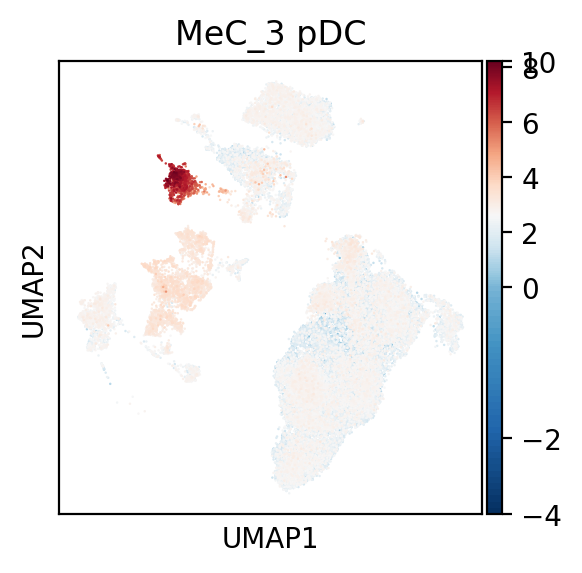

In [13]:
fig=plmapper.plot_umap_mec( pdata, 'MeC_3' ,mecnamedict, figfile =None)

### Plot signature continuum for all functional MeCs

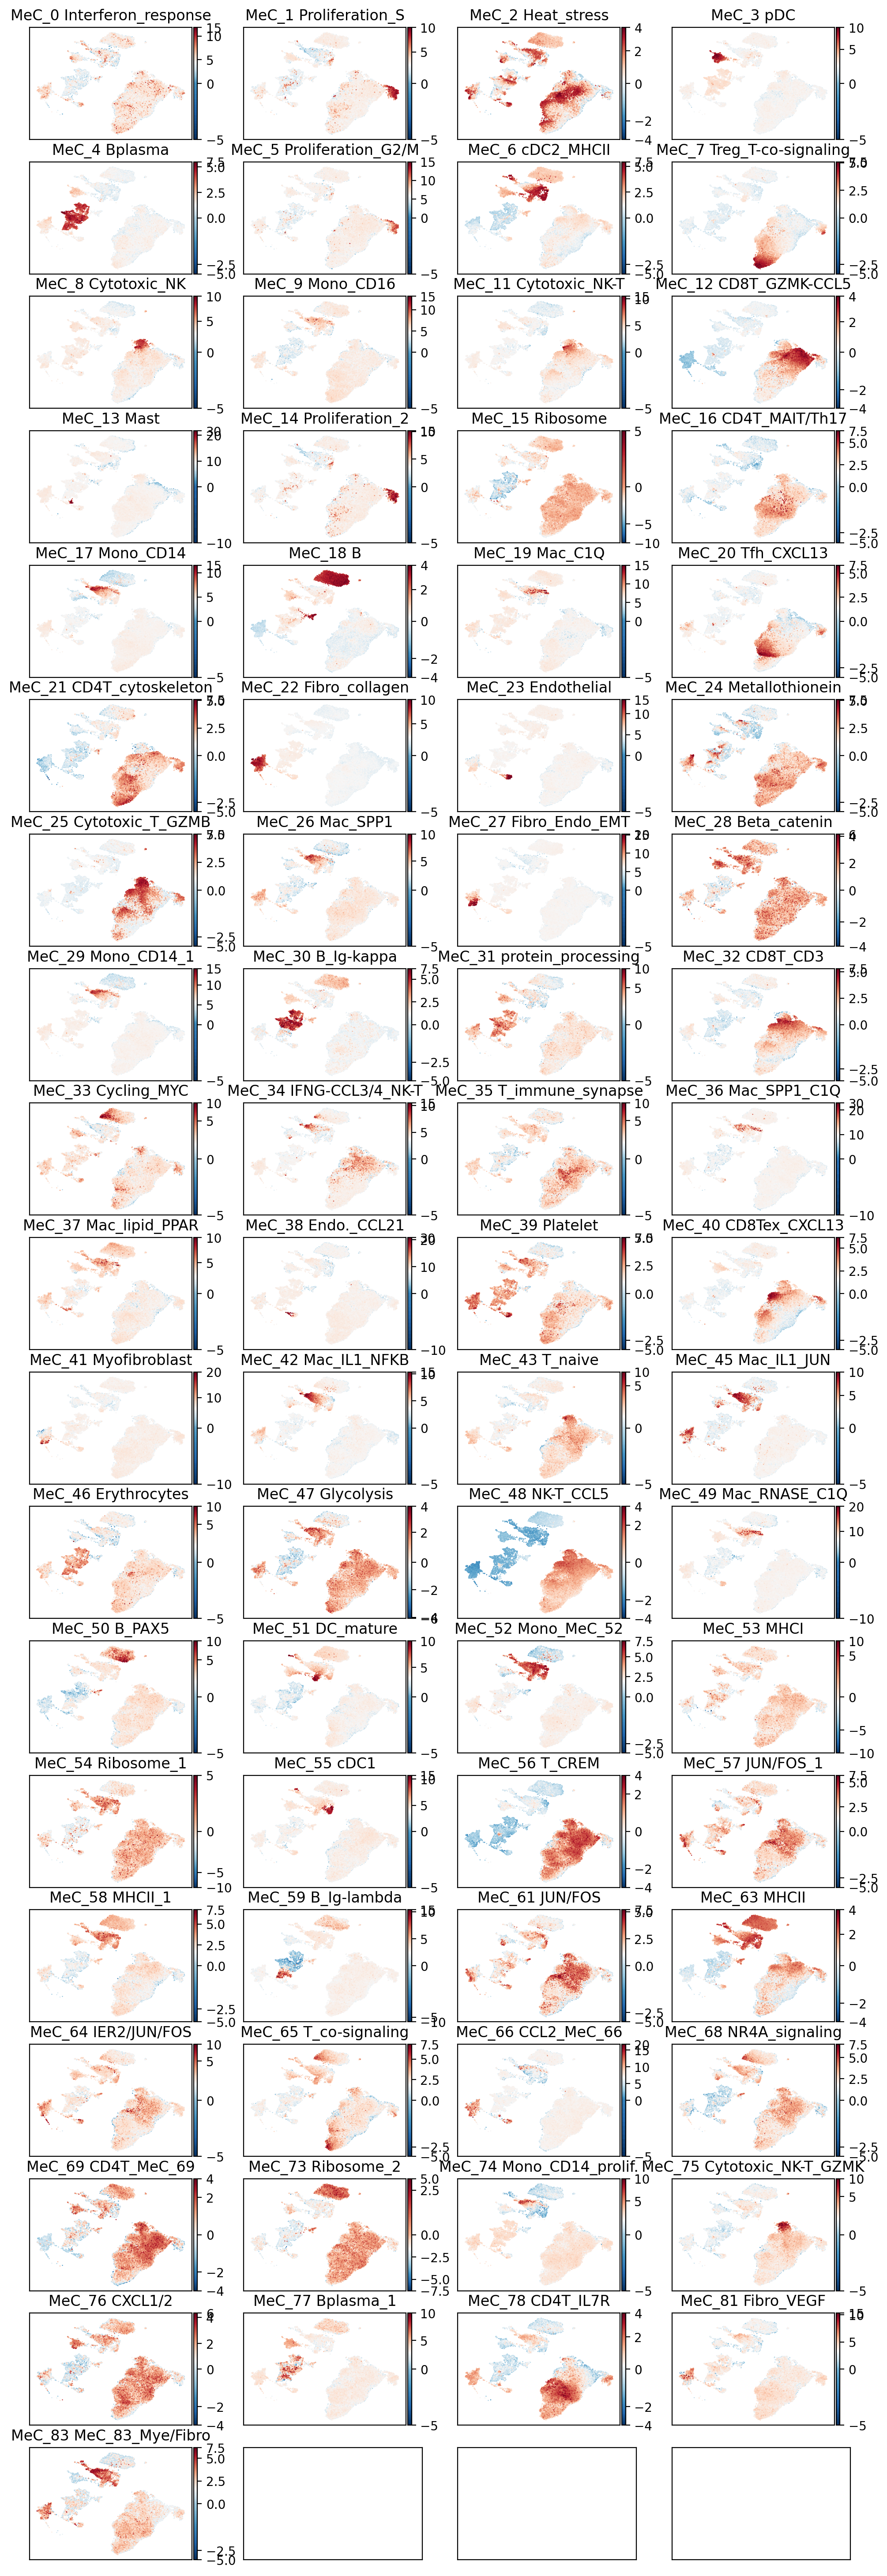

In [14]:
fig=plmapper.plot_umap_proj_pdata( pdata, mecnamedict , figfile =None)